# Naural network hidden layers activation embeding

#### In this notebook we will use fully connected neural network for a classification task to improve visualizations algorithm from previous classes.

In the fully connected neural network, the output of each layer is computed using the activations from the previous one. In neural network training process, each successive layer learns to extract features from data with increasingly higher levels of abstraction. In this exercise, instead of directly visualizing data, we'll try to visualize the activation of hidden layers in neural networks. Using this idea, we can improve the process of data visualization, and on the other hand, see how processing this data looks like by a neural network.

In the first stage, we define simple architecture of the neural network and train it to recognize digits in the MNIST dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from keras import backend as K

from keras.datasets import mnist
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

import umap
import umap.plot
from umap import UMAP
from sklearn.manifold import TSNE

%matplotlib inline
plt.rcParams["animation.html"] = "jshtml"

import warnings
warnings.filterwarnings('ignore')

c:\users\asrock\desktop\studia\ds\sem1\wdzd\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nb_classes = 10

The dropout layers have the very specific function to drop out a random set of activations in that layers by setting them to zero in the forward pass. Simple as that.
It allows to avoid overfitting but has to be used only at training time and not at test time.

In [3]:
# set dropout rate - fractions of neurons to drop
dropout = 0.5

In [4]:
# build very simple neural network with 2 hidden layers

model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(784,)))
model.add(Dropout(dropout))
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])

In [5]:
# The binary_crossentropy loss expects a one-hot-vector as input,
# so we apply the to_categorical function from keras.utilis to convert integer labels to one-hot-vectors.
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 2s 0us/step


In [6]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

# Put everything on grayscale
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [7]:
# split training and validation data
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, train_size=5/6)

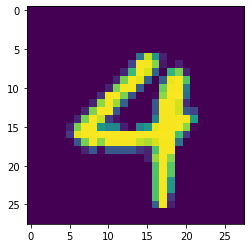

In [8]:
# show example digit
plt.imshow(X_train[0].reshape(28, 28))

In [9]:
# When we have defined and compiled the model, it can be trained using the fit function.
# We also use validation dataset to monitor validation loss and accuracy.

network_history = model.fit(X_train, Y_train, batch_size=128, 
                            epochs=20, verbose=1, validation_data=(X_val, Y_val))

Epoch 1/20
391/391 [==============================] - 2s 3ms/step - loss: 0.6498 - accuracy: 0.7971 - val_loss: 0.2175 - val_accuracy: 0.9346
Epoch 2/20
391/391 [==============================] - 1s 3ms/step - loss: 0.3036 - accuracy: 0.9146 - val_loss: 0.1584 - val_accuracy: 0.9522
Epoch 3/20
391/391 [==============================] - 1s 3ms/step - loss: 0.2431 - accuracy: 0.9322 - val_loss: 0.1403 - val_accuracy: 0.9601
Epoch 4/20
391/391 [==============================] - 1s 3ms/step - loss: 0.2056 - accuracy: 0.9413 - val_loss: 0.1311 - val_accuracy: 0.9639
Epoch 5/20
391/391 [==============================] - 1s 3ms/step - loss: 0.1858 - accuracy: 0.9481 - val_loss: 0.1182 - val_accuracy: 0.9671
Epoch 6/20
391/391 [==============================] - 1s 3ms/step - loss: 0.1685 - accuracy: 0.9530 - val_loss: 0.1099 - val_accuracy: 0.9692
Epoch 7/20
391/391 [==============================] - 1s 3ms/step - loss: 0.1561 - accuracy: 0.9552 - val_loss: 0.1062 - val_accuracy: 0.9710
Epoch 

In [10]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

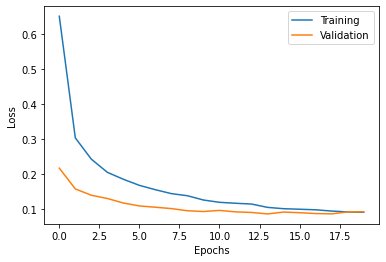

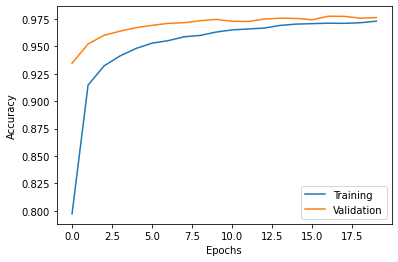

In [11]:
# fit function return keras.callbacks.History object which contains the entire history
# of training/validation loss, accuracy and other metrices for each epoch.
# We can therefore plot the behaviour of loss and accuracy during the training phase.

plot_history(network_history)

In [12]:
# Keras Model have summary function, that print data about model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 218,058
Trainable params: 218,058
Non-trainable params: 0
_________________________________________________________________


In [13]:
# We are interested in downloading the activation of hidden layers, because the dropout layers are between them,
# we need to properly select the index of the three dense layers.

# In the function K.function(), the first argument is input to this model and second is set of 2 outputs
# one for convolution and second for softmax output at the last layer.

get_layer_output = K.function([model.layers[0].input],
                              [model.layers[0].output, model.layers[2].output, model.layers[4].output])

layer1_output, layer2_output, layer3_output = get_layer_output([X_train])

# Skipt dropout layers while numering variables
print(f"Layer 1 output shape: {layer1_output.shape}")
print(f"Layer 2 utput shape: {layer2_output.shape}")
print(f"Layer 3 output shape: {layer3_output.shape}")

Layer 1 output shape: (50000, 256)
Layer 2 utput shape: (50000, 64)
Layer 3 output shape: (50000, 10)


In [14]:
# Pobranie indeksów próbek dla każdej z klas należących do len(Y_train) 
train_ids = [np.arange(len(Y_train))[Y_train[:,i] == 1] for i in range(10)]
train_ids

[array([    3,    16,    36, ..., 49960, 49971, 49991]),
 array([    2,     5,    12, ..., 49987, 49992, 49995]),
 array([    1,    18,    25, ..., 49973, 49982, 49994]),
 array([    7,     9,    10, ..., 49962, 49969, 49989]),
 array([    0,    13,    20, ..., 49953, 49968, 49990]),
 array([    4,     8,    28, ..., 49976, 49978, 49999]),
 array([   27,    41,    46, ..., 49980, 49984, 49993]),
 array([    6,    15,    22, ..., 49970, 49996, 49998]),
 array([   34,    57,    62, ..., 49986, 49988, 49997]),
 array([   14,    19,    40, ..., 49912, 49913, 49977])]

The 2 graphs below are not directly related to the topic of the exercise, but they visualize very well how neuron activation actives work and for explanation are included.

In [15]:
%%capture
%matplotlib inline

# this animation shows what the example number 5 looks like
# and what activations of neurons look in hidden layers of the neural network



# digit to be plotted
digit = 5

# indices of frames to be plotted for this digit
n = range(50)

# initialize plots
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,4))

# prepare plots
ax1.set_title('Input Layer', fontsize=16)
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)

ax2.set_title('Hidden Layer 1', fontsize=16)
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

ax3.set_title('Hidden Layer 2', fontsize=16)
ax3.axes.get_xaxis().set_visible(False)
ax3.axes.get_yaxis().set_visible(False)
    
ax4.set_title('Output Layer', fontsize=16)
ax4.axes.get_xaxis().set_visible(False)
ax4.axes.get_yaxis().set_visible(False)   

# add numbers to the output layer plot to indicate label
for i in range(3):
    for j in range(4):
        text = ax4.text(j, i, [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, '', '']][i][j],
                        ha="center", va="center", color="w", fontsize=16)    
        
def animate(id):
    # plot elements that are changed in the animation
    digit_plot = ax1.imshow(X_train[train_ids[digit][id]].reshape((28,28)), animated=True)
    layer1_plot = ax2.imshow(layer1_output[train_ids[digit][id]].reshape((16,16)), animated=True)
    layer2_plot = ax3.imshow(layer2_output[train_ids[digit][id]].reshape((8,8)), animated=True)
    output_plot = ax4.imshow(np.append(layer3_output[train_ids[digit][id]], 
                                       [np.nan, np.nan]).reshape((3,4)), animated=True)
    return digit_plot, layer1_plot, layer2_plot, output_plot,

# define animation
ani = matplotlib.animation.FuncAnimation(f, animate, frames=n, interval=100)

In [16]:
ani

In most cases the same subset of neurons fires, while other neurons remain quiescent. This is much more obvious in the second hidden layer than in the first hidden layer and can be interpreted as the first layer pre-processesing the pixel data, while the second layer deals with pattern recognition.

This effect is mainly caused by regularization forced by dropout. Dropout generally leads to the sparse weight matrices where a significant part of connection weights are close to 0. Insignificant weights are suppressed.


Optional, nonobligatory task:
You can easily see how the visualizations change if you comment lines responsible for the dropout "model.add(Dropout(dropout))".
Remember to change "get_layer_output", because after removing the dropout, the dense layers will have indexes: 0,1,2.


In [17]:
%%capture
%matplotlib inline


# Let's check the similarity in behavior for frames showing the same digit by looking at the ensemble properties.
# In this case, ensemble properties refers to how the neurons behave on average
# for a large number of frames showing the same digit.

# digit to be plotted
digit = 6

# numbers of frames to be summed over
n = np.append([1], np.linspace(5, 100, 20, dtype=int))

# initialize plots
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,4))

# add a counter indicating the number of frames used in the summation
counter = ax1.text(1, 2, 'n={}'.format(0), color='white', fontsize=16, animated=True)

# prepare plots
ax1.set_title('Input Layer', fontsize=16)
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)

ax2.set_title('Hidden Layer 1', fontsize=16)
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

ax3.set_title('Hidden Layer 2', fontsize=16)
ax3.axes.get_xaxis().set_visible(False)
ax3.axes.get_yaxis().set_visible(False)
    
ax4.set_title('Output Layer', fontsize=16)
ax4.axes.get_xaxis().set_visible(False)
ax4.axes.get_yaxis().set_visible(False)   

# add numbers to the output layer plot to indicate label
for i in range(3):
    for j in range(4):
        text = ax4.text(j, i, [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, '', '']][i][j],
                        ha="center", va="center", color="w", fontsize=16)    
        
def animate(id):
    # plot elements that are changed in the animation
    digit_plot = ax1.imshow(np.sum(X_train[train_ids[digit][:id]], axis=0).reshape((28,28)), animated=True)
    layer1_plot = ax2.imshow(np.sum(layer1_output[train_ids[digit][:id]], axis=0).reshape((16,16)), animated=True)
    layer2_plot = ax3.imshow(np.sum(layer2_output[train_ids[digit][:id]], axis=0).reshape((8,8)), animated=True)
    output_plot = ax4.imshow(np.append(np.sum(layer3_output[train_ids[digit][:id]], axis=0), 
                                       [np.nan, np.nan]).reshape((3,4)), animated=True)
    counter.set_text('n={}'.format(id))
    return digit_plot, layer1_plot, layer2_plot, output_plot, counter,

# define animation
ani = matplotlib.animation.FuncAnimation(f, animate, frames=n, interval=100)

In [18]:
ani

After summing up the responses of as little as 20-30 frames, the pattern in the second hidden layer is almost static. After combining about 70-80 frames, also the pattern in the first hidden layer appears static. This supports the idea that only a subset of all neurons is involved in the recognition of individual digits.

Especially the above plot is important when we think about use of neural networks for data visualization. We can clearly see that the activation generated by examples belonging to the same class are less chaotic than the examples themselves, therefore their visualization should give a more clustered structure

# Homework

- project a mnist training part into 2-dimensional space using t-SNE and UMAP.

- use layer1_output and layer2_output to project first and second hidden layers of neural network into a 2-dimensional space. Also divided into a test and training set, use the same methods as the point above.

- also visualize the test part.

- Try to use 2-dimensional projection for classification task.

- Use embeddings lerned on raw train data (and also on hidden activations of train data) to transform test data (and also hidden activations of test data) into 2-dimensional space.

- Use the k-nearest neighbors algorithm to classify transformed points from the test set. Use the KNN algorithm in which you will use points from the training set as a neighbor with known class assignment. Becouse t-SNE is a non-linear, non-parametric embedding you cant use already learned t-SNE to transform new points into the existing embedded space. So for this part, use only UMAP with have fit_transform method (learn manifold) and also transform (only project new data to existing manifold). Try with few values of n_neighbors e.g [3, 5, 10]

- Estimate the accuracy of classification using this approach. Use all 3 layers (raw data, 1 hidden layer, 2 hidden layer) and few values of n_neighbors

In [19]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

# Put everything on grayscale
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [20]:
def plot_2d_mnist_scatter(X, y):
    fig, plot = plt.subplots()
    fig.set_size_inches(10, 10)
    plt.prism()

    for i in range(10): 
        digit_indices = (y == i)
        dim0 = X[digit_indices, 0]
        dim1 = X[digit_indices, 1]
        plot.scatter(dim0, dim1, label=f"Digit {i}")


    plot.set_xticks(())
    plot.set_yticks(())

    plt.tight_layout()
    plt.legend()
    plt.show()

#### Projection of MNIST (testing and training) part into 2-dimenstional space using t-SNE

In [21]:
test_mnist_tsne_embedding = TSNE(n_components=2, perplexity=40).fit_transform(X_test)
train_mnist_tsne_embedding = TSNE(n_components=2, perplexity=40).fit_transform(X_train)

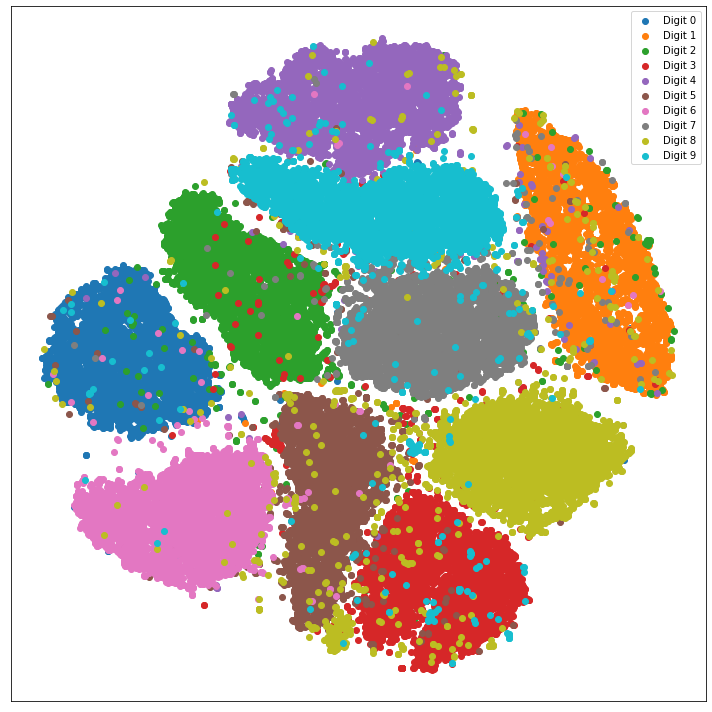

In [22]:
plot_2d_mnist_scatter(train_mnist_tsne_embedding, y_train)

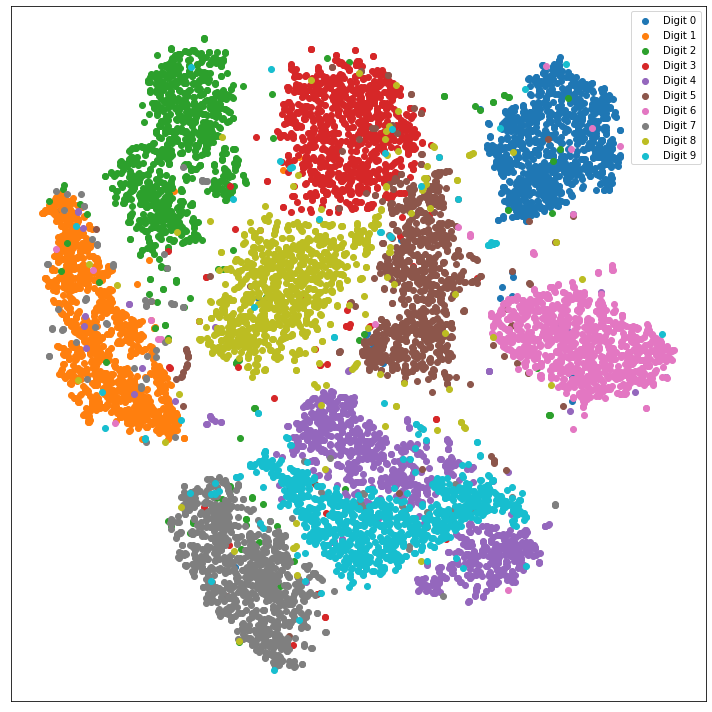

In [23]:
plot_2d_mnist_scatter(test_mnist_tsne_embedding, y_test)

#### Projection of MNIST (testing and training) part into 2-dimenstional space using UMAP

In [24]:
test_mnist_umap_reducer, train_mnist_umap_reducer = UMAP(), UMAP()
test_mnist_umap_embedding = test_mnist_umap_reducer.fit_transform(X_test)
train_mnist_umap_embedding = train_mnist_umap_reducer.fit_transform(X_train)

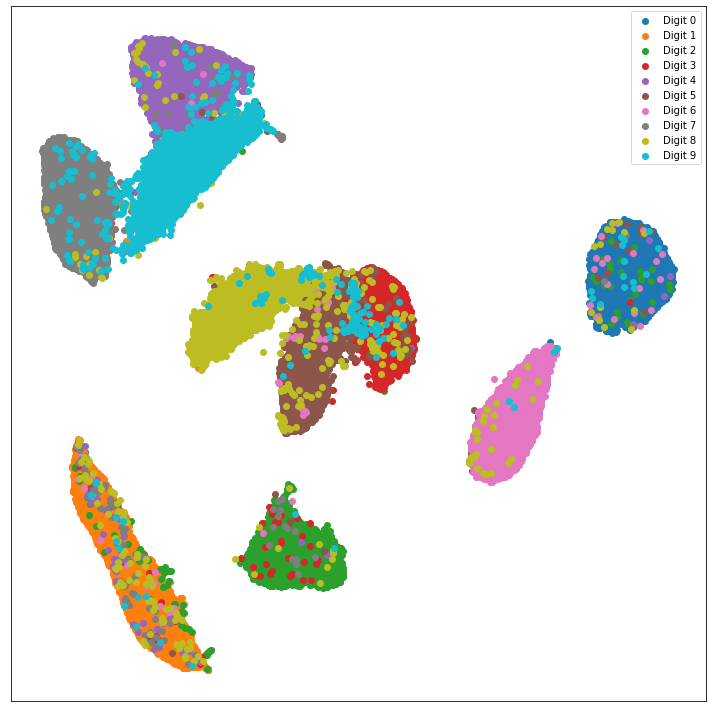

In [25]:
plot_2d_mnist_scatter(train_mnist_umap_embedding, y_train)

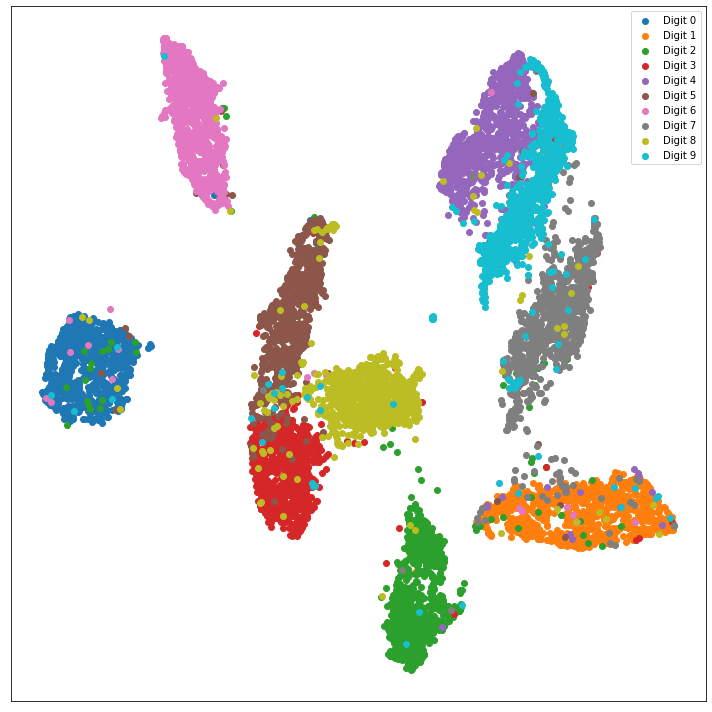

In [26]:
plot_2d_mnist_scatter(test_mnist_umap_embedding, y_test)

#### Use layer1_output and layer2_output (testing and training) to project first and second hidden layer of neural network into 2D

In [27]:
test_layer1_output, test_layer2_output, test_layer3_output = get_layer_output([X_test])
train_layer1_output, train_layer2_output, train_layer3_output = get_layer_output([X_train])
# maybe you would like to inverse of "to_categorical" function. use np.argmax(to_categorical(x, k), axis=1) or K.argmax.

#### Projection of layer1_output (testing and training) into 2-dimenstional space usint t-SNE

In [28]:
test_layer1_output_tsne_embedding = TSNE(n_components=2, perplexity=40).fit_transform(test_layer1_output)
train_layer1_output_tsne_embedding = TSNE(n_components=2, perplexity=40).fit_transform(train_layer1_output)

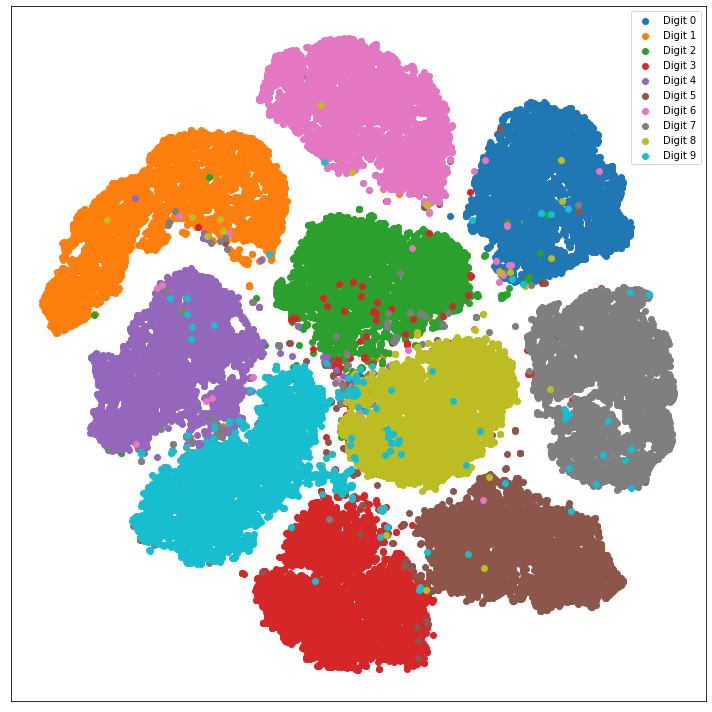

In [29]:
plot_2d_mnist_scatter(train_layer1_output_tsne_embedding, y_train)

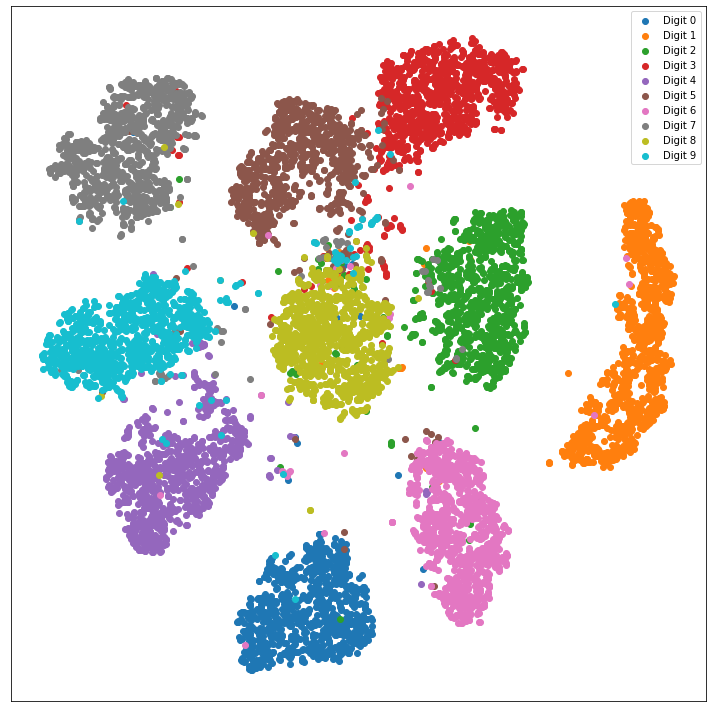

In [30]:
plot_2d_mnist_scatter(test_layer1_output_tsne_embedding, y_test)

#### Projection of layer2_output (testing and training) into 2-dimenstional space usint t-SNE

In [31]:
test_layer2_output_tsne_embedding = TSNE(n_components=2, perplexity=40).fit_transform(test_layer2_output)
train_layer2_output_tsne_embedding = TSNE(n_components=2, perplexity=40).fit_transform(train_layer2_output)

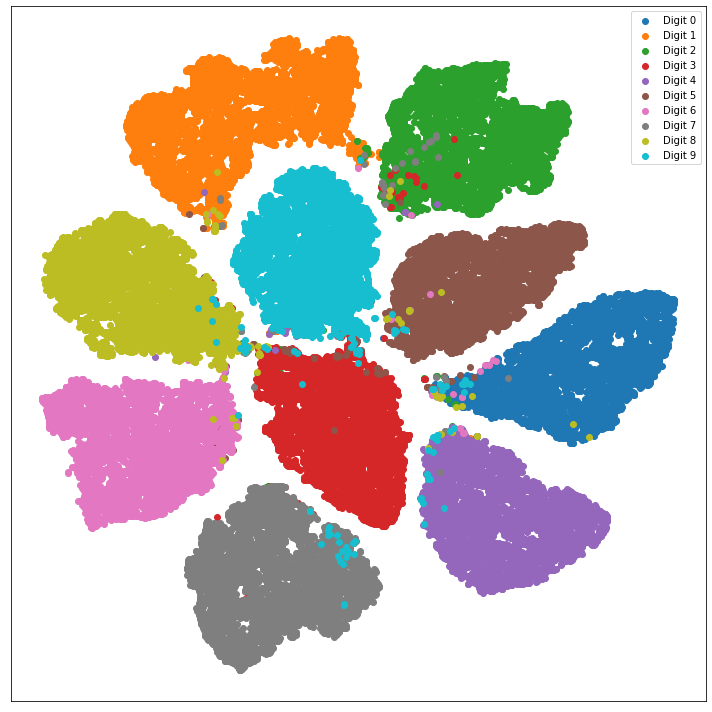

In [32]:
plot_2d_mnist_scatter(train_layer2_output_tsne_embedding, y_train)

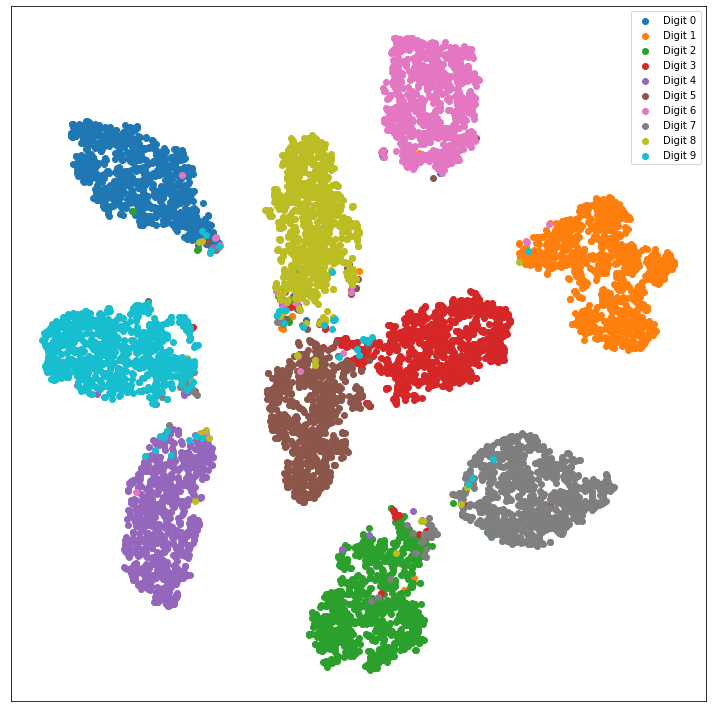

In [33]:
plot_2d_mnist_scatter(test_layer2_output_tsne_embedding, y_test)

#### Projection of layer1_output (testing and training) into 2-dimenstional space using UMAP

In [34]:
test_layer1_umap_reducer, train_layer1_umap_reducer = UMAP(), UMAP()
test_layer1_output_umap_embedding = test_layer1_umap_reducer.fit_transform(test_layer1_output)
train_layer1_output_umap_embedding = train_layer1_umap_reducer.fit_transform(train_layer1_output)

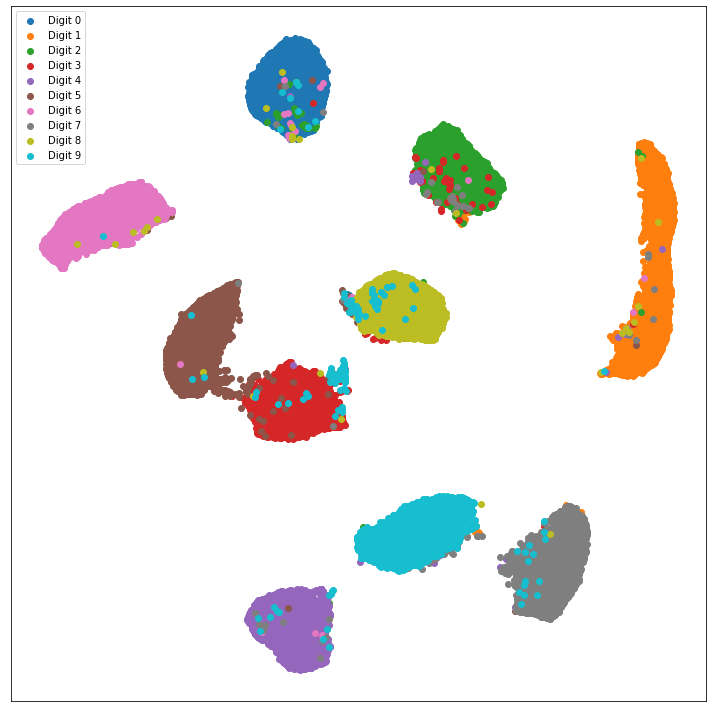

In [35]:
plot_2d_mnist_scatter(train_layer1_output_umap_embedding, y_train)

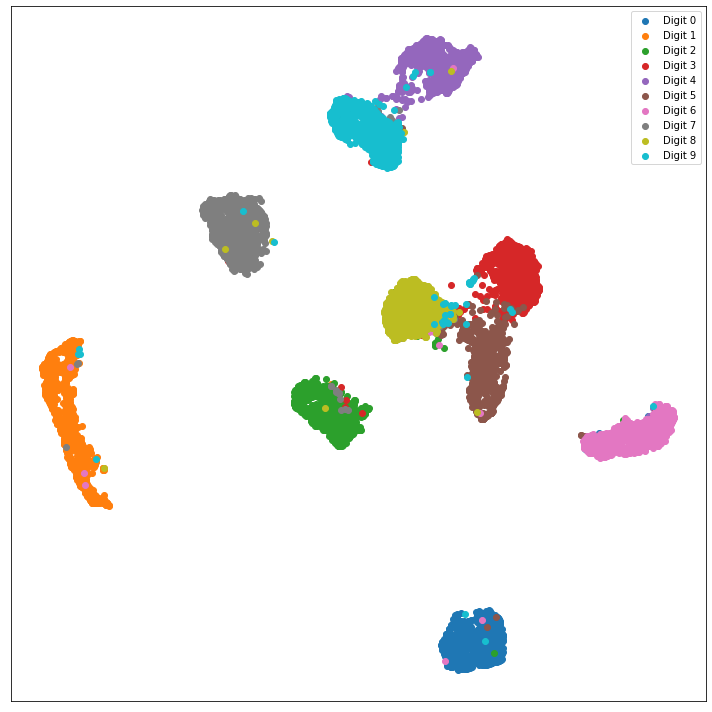

In [36]:
plot_2d_mnist_scatter(test_layer1_output_umap_embedding, y_test)

#### Projection of layer2_output (testing and training) into 2-dimenstional space using UMAP

In [37]:
test_layer2_umap_reducer, train_layer2_umap_reducer = UMAP(), UMAP()
test_layer2_output_umap_embedding = test_layer2_umap_reducer.fit_transform(test_layer2_output)
train_layer2_output_umap_embedding = train_layer2_umap_reducer.fit_transform(train_layer2_output)

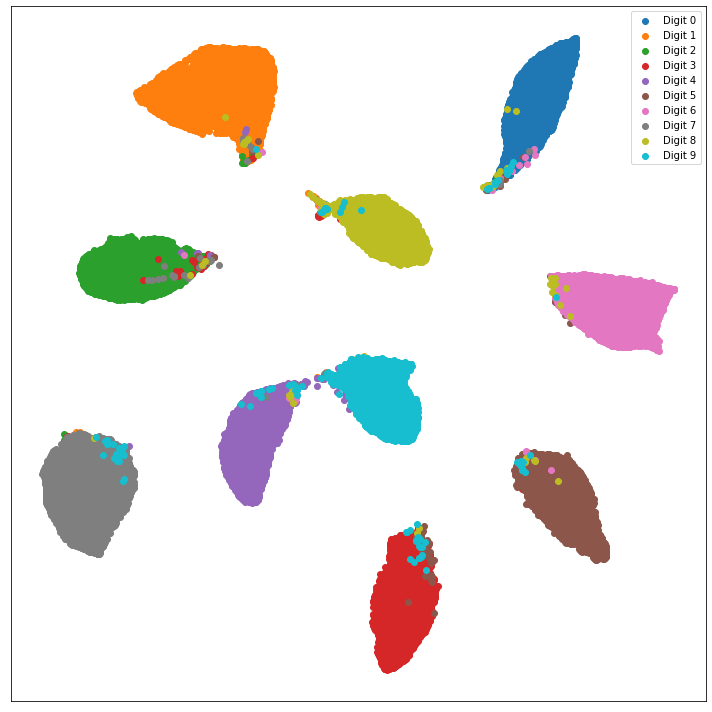

In [38]:
plot_2d_mnist_scatter(train_layer2_output_umap_embedding, y_train)

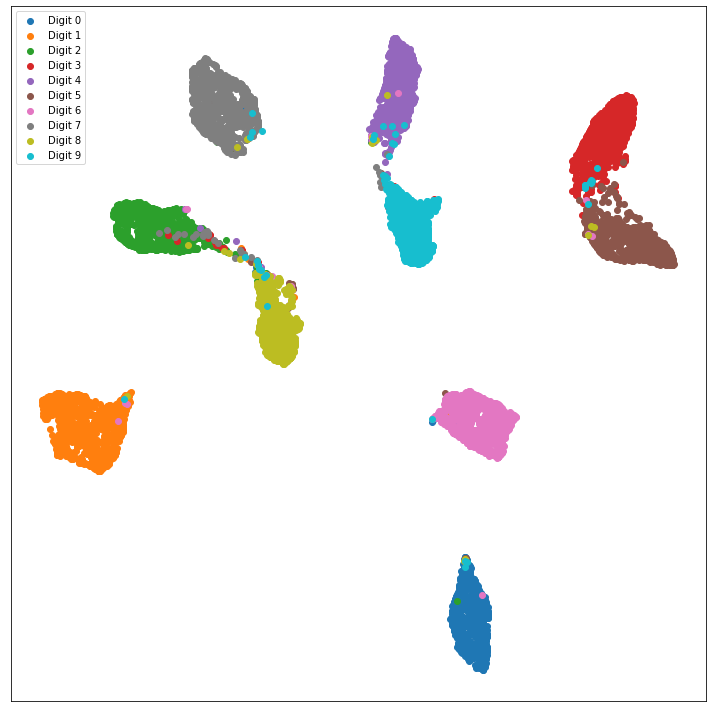

In [39]:
plot_2d_mnist_scatter(test_layer2_output_umap_embedding, y_test)

#### Using KNN to evaluate accuracy of data embedding technique - UMAP

In [40]:
from sklearn.neighbors import KNeighborsClassifier as KNN

In [41]:
trans = umap.UMAP().fit(X_train)
knn = KNN(n_neighbors=5).fit(trans.embedding_, y_train)
knn.score(trans.transform(X_test), y_test)

0.9535

In [42]:
trans_layer_1_output = umap.UMAP().fit(train_layer1_output)
knn_layer_1_output = KNN(n_neighbors=5).fit(trans_layer_1_output.embedding_, y_train)
knn_layer_1_output.score(trans_layer_1_output.transform(test_layer1_output), y_test)

0.9698

In [43]:
trans_layer_2_output = umap.UMAP().fit(train_layer2_output)
knn_layer_2_output = KNN(n_neighbors=5).fit(trans_layer_2_output.embedding_, y_train)
knn_layer_2_output.score(trans_layer_2_output.transform(test_layer2_output), y_test)

0.9768

#### Evaluation against different values of k

In [44]:
from matplotlib.pyplot import bar

In [45]:
def evaluate_embedding_using_KNN(X_train, y_train, X_test, y_test):
    K_range = range(1, 10, 2)
    scores = []
    for i in K_range:
        trans = umap.UMAP().fit(X_train)
        knn = KNN(n_neighbors=i).fit(trans.embedding_, y_train)
        scores.append(
            (i, knn.score(trans.transform(X_test), y_test))
        )
        print(f"Evaluation for k={i} done.")

    return scores

In [46]:
def plot_KNN_accuracy(data_score):
    x = list(map(str, list(zip(*data_score))[0]))
    y = list(zip(*data_score))[1]

    plt.barh(x, y)
    plt.title("Accuracy of KNN-based clasification in relation to the k value.")
    for index, value in enumerate(y):
        plt.text(value, index, str(value))

    plt.xlim(float(str(min(y))[:-2]))

    plt.show()

In [47]:
data_score = evaluate_embedding_using_KNN(X_train, y_train, X_test, y_test)

Evaluation for k=1 done.
Evaluation for k=3 done.
Evaluation for k=5 done.
Evaluation for k=7 done.
Evaluation for k=9 done.


In [48]:
data_score

[(1, 0.9316), (3, 0.9532), (5, 0.9558), (7, 0.9544), (9, 0.956)]

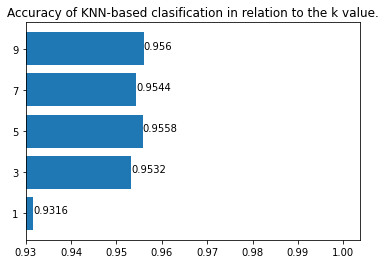

In [49]:
plot_KNN_accuracy(data_score)

In [50]:
layer1_output_score = evaluate_embedding_using_KNN(
    train_layer1_output, y_train,
    test_layer1_output, y_test
)

Evaluation for k=1 done.
Evaluation for k=3 done.
Evaluation for k=5 done.
Evaluation for k=7 done.
Evaluation for k=9 done.


In [51]:
layer1_output_score

[(1, 0.9639), (3, 0.9704), (5, 0.9699), (7, 0.9709), (9, 0.9712)]

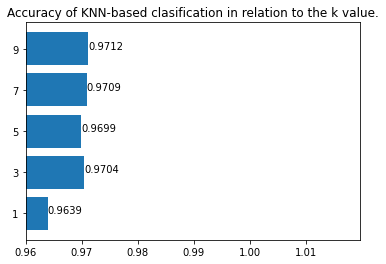

In [52]:
plot_KNN_accuracy(layer1_output_score)

In [53]:
layer2_output_score = evaluate_embedding_using_KNN(
    train_layer2_output, y_train,
    test_layer2_output, y_test
)

Evaluation for k=1 done.
Evaluation for k=3 done.
Evaluation for k=5 done.
Evaluation for k=7 done.
Evaluation for k=9 done.


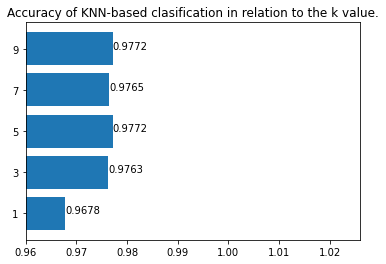

In [54]:
plot_KNN_accuracy(layer2_output_score)

### Conclusions

KNN classifier can be used to measure embedding accuracy.
In the first experiment, KNN has been tested against UMAP embedding of the original MNIST dataset. (As mentioned in the task description, UMAP can be evaluated in such experiment because of separate fit and transform methods. Firstly the data can be fitted using UMAP reducer to "learn manifold", then KNN classifier can fit to the obtained representation and finally new points can be classified and accuracy score measured). According to the expectations, the same process have been carried out for layer1_output data and layer_2 output data (neural network layers) and gave much better results in terms of accuracy. Each subsequent layer of the neural network (the overall purpose of which is to recognize the internal data structure so that it can correctly classify on completely new data) is responsible for recognizing more and more complex hidden eatures in data. Finally, data obtained from the output of subsequent network layers is already the data after recognizing certain structures, therefore KNN accuracy is higher. <br><br>

KNN Raw Data Accuracy < KNN Layer 1 output Data Accuracy < KNN Layer 2 output Data Accuracy <br><br>

Neural Networks can be used to improve the classification task. Rather than having to embedd the original data, we can use the outputs from neural network layers, embed them, and obtain the better classification accuracy the better accuracy of neural network is. It is also extremely important to select the appropriate value of the parameter k, which does not necessarily give greater accuracy the higher the parameter is - based on the bar plots presented above.